# How can we predict the value of the S&P 500?
Jasper Hsu, Thomas Suman, Trey Hensel

## Libraries and dependencies:

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
import statsmodels.api as sm
import seaborn as sns

## Loading the data: 
https://www.kaggle.com/datasets/gkitchen/s-and-p-500-spy

In [5]:
df = pd.read_csv("spy.csv")

First, we must decide what we are trying to predict. Our dataset supplies us with four options: open, high, low, and close. Predicting the high and low values of the stock on a given day is a seemingly good idea, but this information is hard to use because it is also dependent on time - and we aren't given any data on when the stock hits either extremity. Predicting the value of the stock when the market opens is definitely useful, but it generally doesn't reflect the overall market sentiment and may be heavily influenced by unpredictable overnight news or events. On the other hand, the closing price of a stock reflects the overall market sentiment and demand for the stock at the end of the trading day. It is also widely used as a benchmark for measuring the performance of the stock market. Thus, we will be predicting the closing price.

## Test/train split:

In [20]:
df = df.sample(frac = 1) # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = len(df)
split = math.floor(n*train_proportion)

target = df["Close"]
features = ["Open", "High", "Low", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
data = df.loc[:, df.columns.isin(features)]

# the following variable records the features of examples in the training set
train_x = data.iloc[:split]
# the following variable records the features of examples in the test set
test_x = data.iloc[split+1:]
# the following variable records the labels of examples in the training set
train_y = target[:split]
# the following variable records the labels of examples in the test set
test_y = target[split+1:]

Note that we effectively removed the "Date" column from our data as the same information is stored separately in the "Day", "Month", and "Year" columns.

## Attempt #1: Linear Regression Model

Train MSE	 0.5438316106075932
Test MSE	 0.6864684458462622


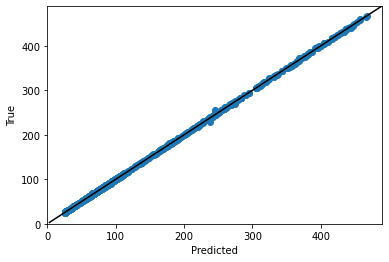

In [40]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.mean(np.square(np.subtract(y, pred)))

# This function plots the main diagonal;for a "predicted vs true" plot with perfect predictions, all data lies on this line
def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

# This helper function plots x vs y and labels the axes
def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()

# This function plots the predicted labels vs the actual labels (We only plot the first 1000 points to avoid slow plots)
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted', 'True', zeromin=True)

def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None
            
    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.array(np.matmul(train_vals,w))
    test_pred = np.array(np.matmul(test_vals,w))
    
    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred

train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_x, test_x)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)